# Without LoRA

In [3]:
from fastai.vision.all import *

path = Path('/home/dnth/Desktop/sdnet-detect-dataset/Walls')

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75)]
)


In [4]:
dls = dblock.dataloaders(path, bs=64)

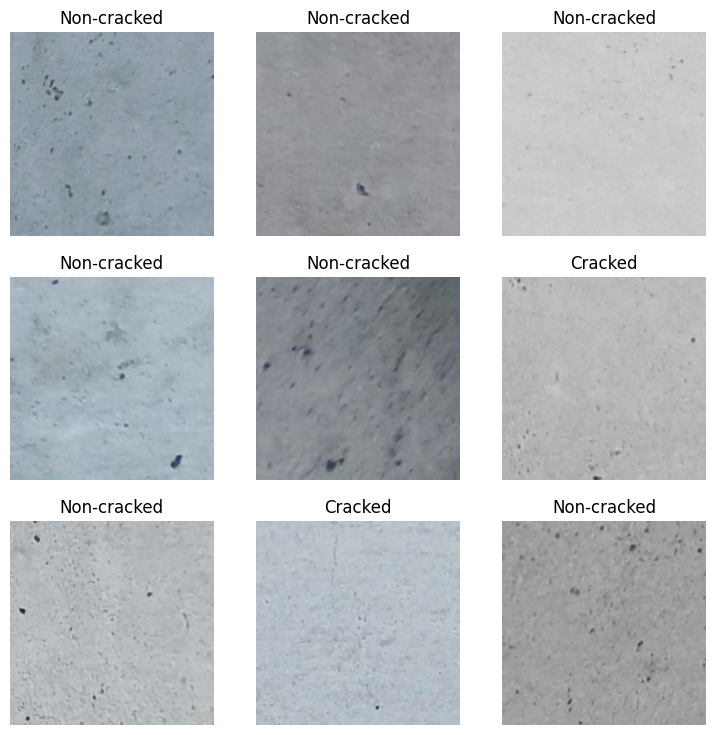

In [6]:
dls.show_batch()

In [7]:
learn = vision_learner(dls, "resnet50", metrics=[error_rate, accuracy])

def count_parameters(model):
    trainable_params = 0
    non_trainable_params = 0
    
    for param in model.parameters():
        if param.requires_grad:
            trainable_params += param.numel()
        else:
            non_trainable_params += param.numel()
    
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")
    print(f"Total parameters: {trainable_params + non_trainable_params:,}")
    
    return trainable_params, non_trainable_params

count_parameters(learn.model)


# for name, param in learn.model.named_parameters():
#     print(f"{name}: requires_grad = {param.requires_grad}")

learn.summary()

Trainable parameters: 2,160,512
Non-trainable parameters: 23,454,912
Total parameters: 25,615,424


/home/dnth/anaconda3/envs/fastai_ssl/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                  

In [8]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.667946,0.444381,0.171216,0.828784,00:45
1,0.439988,0.363296,0.143369,0.856631,00:44
2,0.391641,0.349298,0.131514,0.868486,00:44


## With LoRA

In [14]:
# from fastai.vision.all import *
from lora_adapters import LoraConv2d, apply_adapter, mark_only_lora_as_trainable

# path = untar_data(URLs.PETS)/'images'
# dls = ImageDataLoaders.from_name_func(
#     path, get_image_files(path), valid_pct=0.2,
#     label_func=lambda x: x[0].isupper(), item_tfms=Resize(224))

learn = vision_learner(dls, "resnet50", metrics=[error_rate, accuracy])

# freeze all layers
# for param in learn.model.parameters():
#     param.requires_grad = False

learn.model[0].model = apply_adapter(learn.model[0].model, LoraConv2d, rank=16)
learn.model[0].model = mark_only_lora_as_trainable(learn.model[0].model)


def count_parameters(model):
    trainable_params = 0
    non_trainable_params = 0
    
    for param in model.parameters():
        if param.requires_grad:
            trainable_params += param.numel()
        else:
            non_trainable_params += param.numel()
    
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")
    print(f"Total parameters: {trainable_params + non_trainable_params:,}")
    
    return trainable_params, non_trainable_params


count_parameters(learn.model)

for name, param in learn.model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

learn.summary()

Trainable parameters: 3,910,960
Non-trainable parameters: 23,508,032
Total parameters: 27,418,992
0.model.conv1.weight: requires_grad = False
0.model.conv1.lora_A: requires_grad = True
0.model.conv1.lora_B: requires_grad = True
0.model.bn1.weight: requires_grad = False
0.model.bn1.bias: requires_grad = False
0.model.layer1.0.conv1.weight: requires_grad = False
0.model.layer1.0.conv1.lora_A: requires_grad = True
0.model.layer1.0.conv1.lora_B: requires_grad = True
0.model.layer1.0.bn1.weight: requires_grad = False
0.model.layer1.0.bn1.bias: requires_grad = False
0.model.layer1.0.conv2.weight: requires_grad = False
0.model.layer1.0.conv2.lora_A: requires_grad = True
0.model.layer1.0.conv2.lora_B: requires_grad = True
0.model.layer1.0.bn2.weight: requires_grad = False
0.model.layer1.0.bn2.bias: requires_grad = False
0.model.layer1.0.conv3.weight: requires_grad = False
0.model.layer1.0.conv3.lora_A: requires_grad = True
0.model.layer1.0.conv3.lora_B: requires_grad = True
0.model.layer1.0.bn

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
LoraConv2d                                61936      False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
LoraConv2d                                6144       False     
BatchNorm2d                               128        False     
ReLU                                                           
LoraConv2d                                55296      False     
BatchNorm2d                               128        False     
Identity                                                       
ReLU                                                           
Identity                  

In [15]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.690153,0.460848,0.197684,0.802316,00:54
1,0.454702,0.394942,0.162117,0.837883,00:53
2,0.408267,0.375632,0.153019,0.846981,00:53


In [ ]:
import timm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('resnet50', pretrained=True).to(device)
apply_adapter(model, LoraConv2d, rank=16)

trainable_layers = []
for name, param in model.named_parameters():

    trainable_layers.append((name, param.numel(), param.requires_grad))

    print(f"Layer: {name}")
    print(f"  Trainable: {param.requires_grad}")
    print(f"  Shape: {param.shape}")
    print("---")

In [ ]:
trainable_layers